In [6]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
Get ica component and decide rejecting ones on Enrico data using MNE and - local computer version
===============================================
We firstly import subject list from sbatch 
we define session list (1, 2), state list (VD, FA, OP), reject dict, 
then we import eeglab format Raw data of one state during one session for single subject with MNE package. We apply:
1) make sure that there is event 254 and event 255, and crop the raw data between 254 and 255
2) a notch filter to remove powerline artifact (50 Hz)
3) a 1Hz-100Hz band-pass filter

Then concatenate the data of the same session with annotation engineering, detail utils please turn to 
utils_preProcessingWorkflowJuly05.py
3) ASR and ICA fitting:

====> output = subj+session_ica fif file that save ica mixing matrix for one session for one subject
Note: 
1. exception : subject 36, some subject can have several 254,255 events
------ please refer to excel Enrico recording summary.xlsx
2. events code: state + condition + session 
    1. state: 1:VD 2:FA 3:OP
    2. condition: 1:baseline 2:safe 3:threat
    3. session: 1:session1 2:session2
3. we fix sampling rate at 512 = for those file whose sfreq = 2048, we do a downsampling

Suggestions:
1) decide infomation storage format
2) 

Updated on July 2019

@author: Gansheng TAN aegean0045@outlook.com    based on Manu's codes
"""

##############################################################  Set-up header ###########################################
import mne
import importlib
import numpy as np
import numpy.matlib
from mne.report import Report
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from utils_ASR import *
from utils_PreprocessingWorkflowJuly23UpdatedData import *
from scipy.linalg import toeplitz
from scipy import signal
import sys
import encodings
import os

matplotlib.use('Agg')
mne.set_log_level('WARNING')

##################### OS path in INSERM computer #####################################################################
# raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
# montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
# # report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
# full_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
#
##################### OS path in cluster ######################################################################
raw_data_path = '/mnt/data/gansheng/raw_data/'
montage_fname = '/mnt/data/gansheng/raw_data/Biosemi64_MAS_EOG.locs'
preProc_ica_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/preProc_ica/'
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
# full_epochs_path = '/mnt/data/gansheng/preClean_data/'


########################################## Algorithme parameter ############################################
cutoff = 10
pca_n_comp = 0.98
decim = 2

########################################## Initialization parameter##########################################
subj = sys.argv[1]
# subj = '35'
session_list=['1','2']
#state list defines the concatenating order
# state_list = ['VD','FA','OP']


################################ step00: cut and filter data and concatenate 3 recording in one session ############

###### set up montage
montage_biosemi=mne.channels.read_montage(montage_fname)

###### preproc for each raw file

psd_figs=[]
psd_captions=[]
ASR_figs=[]
ASR_captions=[]

session2conctn_list=[]
############### single subject report ###########################
rep = Report(image_format = 'png', subject = 'subj0'+subj)

for session in session_list:

    reject_state=[]
    conctn_list = []
    conctn_anno_list=[]
    
    epochs_ASR_clean,psd_figs2conctn,psd_captions2conctn,ASR_figs2conctn,ASR_captions2conctn = get_epochs_ASR_clean(subj,session)

    ############### step02 ICA components check ##########################
    if epochs_ASR_clean == False:
        continue
    else:
        psd_figs=psd_figs+psd_figs2conctn
        psd_captions = psd_captions+psd_captions2conctn
        ASR_figs = ASR_figs + ASR_figs2conctn
        ASR_captions = ASR_captions+ASR_captions2conctn
        ica = mne.preprocessing.ICA(n_components=pca_n_comp, method='fastica', random_state=11, max_iter=100)
        ica.fit(epochs_ASR_clean,decim=decim)
        preProc_ica_fname = preProc_ica_path+'subj0'+subj+'session'+session+'preProc_ica.fif'
        ica.save(preProc_ica_fname)

rep.add_figs_to_section(figs=psd_figs, captions=psd_captions, section = 'preprocessed full epochs plot',
                            image_format = 'svg')
rep.add_figs_to_section(figs=ASR_figs, captions=ASR_captions, section = 'preprocessed full epochs plot',
                            image_format = 'svg')
        
f_report = report_path + 'subj0' + subj+' asr report.html'
rep.save(f_report, open_browser = False, overwrite = True)
            
        



OSError: /mnt/data/gansheng/raw_data/Biosemi64_MAS_EOG.locs not found.

In [179]:
##### Visualize ica components and exclude them subjectively
from mne.preprocessing import read_ica
#### GET EPOCHS TO VISUALIZE ICA
import os
import mne
from utils_ASR import *
from utils_PreprocessingWorkflowJuly23UpdatedData import *
%matplotlib qt

def h5ToHtml(rep_fname):
    import mne
    rep = mne.open_report(rep_fname)
    rep_fname = rep_fname[:-1]
    rep_fname = rep_fname[:-1]
    rep.save(rep_name+'html',open_browser=True, overwrite=False)

def get_epochs_ASR_clean2seeICA(subj,session):

    ##################### OS path in INSERM computer #####################################################################
    raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
    montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
#     report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
    # full_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
    #
    ##################### OS path in cluster ######################################################################
#     raw_data_path = '/mnt/data/gansheng/raw_data/'
#     montage_fname = '/mnt/data/gansheng/raw_data/Biosemi64_MAS_EOG.locs'
#     preProc_ica_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/preProc_ica/'
#     report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
    # full_epochs_path = '/mnt/data/gansheng/preClean_data/'


    ########################################## Algorithme parameter ############################################
    cutoff = 10
    ########################################## Initialization parameter##########################################
    state_list = ['VD','FA','OP']
    power_freq_array = [50]
    reject_raw_data_session1 = {'74':['FA','OP','VD'],'62':['FA','OP','VD'],'75':['FA','OP','VD']}
    reject_raw_data_session2 = {'74':['FA','OP','VD'],'62':['FA','OP','VD'],'75':['FA','OP','VD']}

    # bad channel rejection is not apllied in the preproc, bad channels will be defined by eyes later
    #62,74 IS SO SPECIAL, MISS 75 76 77
    bad_channels={'02':{'1':['P2','FC5'],'2':['P2','FC5']},
                  '04':{'2':['FC6']},
                  '07':{'1':['Iz'],'2':['F8','T7','TP8']},
                  '10':{'1':['F8','AF8','F6','Fp1','AF7','FC6','FT8'],'2':['Fp1','Fpz','Fp2','AF8','F8']},
                  '11':{'2':['T8','F4']},
                  '12':{'1':['P2']},
                  '14':{'1':['P2'],'2':['P2']},
                  '16':{'1':['Fp1','AF7','Fp2','AF8'],'2':['Fp1','AF7','Fp2','AF8','F6']},
                  '19':{'1':['P2','T7'],'2':['P2']},
                  '21':{'2':['Iz']},
                  '22':{'1':['T7','TP7','Iz','P1','POz','Pz'],'2':['T7','TP7','Iz']},
                  '25':{'1':['T8','Fp1'],'2':['FC1','C3','PO4','F2','Pz']},
                  '26':{'1':['T8'],'2':['CPz']},
                  '28':{'2':['CP2','PO7','Oz','POz']},
                  '29':{'1':['F3','F5','F7','AF8','F4','F6','F8'],'2':['F6','T7','F3','F5','F7','AF8','F8']},
                  '32':{'1':['P2'],'2':['P2','TP7']},
                  '34':{'1':['P2'],'2':['P2']},
                  '35':{'1':['T7','T8'],'2':['T8','PO8']},
                  '36':{'1':['P2','PO4'],'2':['P2','PO4']},
                  '37':{'1':['Iz']},
                  '38':{'2':['C5','FC5','TP8']},
                  '39':{'1':['P2','F8','AF8','Fp1','AF7'],'2':['P2','FT8','AF8','T8','P10']},
                  '40':{'1':['P2','TP7'],'2':['P2','TP7']},
                  '42':{'1':['P2'],'2':['P2']},
                  '50':{'1':['T7']},
                  '51':{'1':['P2'],'2':['P2']},
                  '53':{'1':['T7'],'2':['T7']},
                  '54':{'1':['P2'],'2':['P2']},
                  '55':{'1':['Iz']},
                  '56':{'1':['P2','T7'],'2':['P2','TP7']},
                  '57':{'1':['P2'],'2':['P2']},
                  '58':{'1':['P2','T8'],'2':['PO4']},
                  '59':{'1':['P2','PO4']},
                  '60':{'1':['P2'],'2':['P2']},
                  '63':{'2':['PO8']},
                  '64':{'1':['C1']},
                  '65':{'1':['P2'],'2':['P2']},
                  '67':{'1':['FT8']},
                  '68':{'1':['P2'],'2':['P2']},
                  '70':{'1':['PO4','O2','FC3','FC5','F4','F6'],'2':['PO4','O2','FC5','FC3']},
                  '71':{'1':['P2','Iz'],'2':['P2','Iz','C1','Cz']},
                  '73':{'2':['FCz','FT8']},
                #'75':{'1':['C6','P2','FT8','AF8','CP1','P9','PO4','O2']},
                  '76':{'2':['T7']},
                  '77':{'1':['F6'],'2':['O1','Oz','F6','O2']},
                  '78':{'1':['P2'],'2':['P2']},
                  '79':{'1':['P2','POz'],'2':['P2','POz','T7','Fp1','AF7']},
                  '81':{'1':['Iz','Oz','Pz','CPz','PO4','P2','POz'],'2':['Iz','Oz','POz','CPz','P2','PO4','FC1','C1','Pz']},
                  '82':{'1':['P2'],'2':['AFz']},
                  '83':{'1':['T7'],'2':['T7']},
                  '87':{'2':['P2']},
                  '88':{'1':['FC2','T8'],'1':['F4','P8','CP4']},
                  '90':{'1':['T7','P2'],'2':['P2']},
                  '91':{'1':['P2'],'2':['P2']},
                  '93':{'1':['FC5','Fp1','F3','PO4'],'2':['Fp1','F3','FC3','PO4']},
                  '94':{'1':['Fp1','F6','AF8','Fp2','T7','T8'],'2':['Fp1','F6','AF8','Fp2','T7']},
                  '95':{'1':['P2'],'2':['P2']}
                 }
    reject_state = []
    conctn_list = []
    conctn_anno_list=[]
    montage_biosemi=mne.channels.read_montage(montage_fname)

    if subj in eval('reject_raw_data_session'+session).keys():
        reject_state = eval('reject_raw_data_session'+session)[subj]
        print("the rejected states of subject {} in session {} are {}".format(subj,session,reject_state))
    for state in state_list:
        raw_fname = raw_data_path + 'subj0'+subj+'_'+state+session+'_mast.set'
        if state in reject_state:
            continue
        elif os.path.isfile(raw_fname)==False:
            print('raw data file is missing: subject{}, session{}, state{}'.format(subj,session,state))

        else:
            raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')
            if raw.info['sfreq'] != 512:
                raw.resample(sfreq=512, npad = 'auto')
            events = mne.events_from_annotations(raw)
#             if subj == '36' and session == '2' and state == 'VD':
#                 raw.crop(tmin=220)
#                 events = mne.events_from_annotations(raw)
#                 events = events_time_forward(events,220)

            events_coding=events[1]
            events=np.asarray(events[0])  
            if '254' not in events_coding.keys():
                raw.annotations.append(onset=0,duration=0,description='254')
                events = mne.events_from_annotations(raw)
                events_coding=events[1]
                events=np.asarray(events[0])  
            if '255' not in events_coding.keys():
                raw.annotations.append(onset=events[-1][0]/512,duration=0,description='255')
                events = mne.events_from_annotations(raw)
                events_coding=events[1]
                events=np.asarray(events[0])  

            events_code_start = events_coding['254']
            start = events[events[:,2]==events_code_start][0][0]
            events_code_end = events_coding['255']
            stop = events[events[:,2]==events_code_end][0][0]

            raw_cut_filt = raw.copy()
            raw_cut_filt.crop(tmin = start/raw.info['sfreq'], tmax = stop/raw.info['sfreq'])
            raw_cut_filt.notch_filter(freqs=power_freq_array)
            raw_cut_filt.filter(l_freq=1,h_freq=100)

            ############ annotation engineering ################
            index_dlt=0
            for i in range(raw_cut_filt.annotations.__len__()):
                if (raw_cut_filt.annotations.__getitem__(i-index_dlt)['description']) not in ['131','132','255']:
                    raw_cut_filt.annotations.delete(i-index_dlt)
                    index_dlt+=1                       
                else: 
                    continue
            mne_annotation_recode_by_adding(session=session,state=state,annotations=raw_cut_filt.annotations)

            conctn_anno_list.append(raw_cut_filt.annotations)
            conctn_list.append(raw_cut_filt)

################### Concatenation process #################################
    if len(conctn_list)== 0:
        print('nothing 2 concatenate')
        return False,False,False,False,False
    else:        
        full_array = conctn_list[0]._data
        full_info = conctn_list[0].info
        del conctn_list[0]
        for raw2conctn in conctn_list:
            full_array = np.concatenate((full_array,raw2conctn._data),axis=1)
        raw_full = mne.io.RawArray(full_array,info = full_info)
        full_annotation = conctn_anno_list[0]
        del conctn_anno_list[0]
        for annos2conctn in conctn_anno_list:
            mne_annotation_postpone (pptime=full_annotation.__getitem__(full_annotation.__len__()-1)['onset'], 
                                         annotations=annos2conctn)
            full_annotation = full_annotation.__add__(annos2conctn)

        raw_full.set_annotations(full_annotation)
        if subj in bad_channels.keys() and session in bad_channels[subj].keys() :
            raw_full.info['bads']=bad_channels[subj][session]


###########raw_full now is for one session 

        ############### step01: epochs engineering - calibration-epochs-ASR #################################
        rawCalibAsr = raw_full.copy()
        rawCalibAsr = rawCalibAsr.crop(tmin=10,tmax=150)
        rawCalibAsr_noYW = rawCalibAsr.copy()
        rawCalibAsr._data,iirstate = YW_filter(rawCalibAsr._data, rawCalibAsr.info['sfreq'],None)
        rawVEOG= rawCalibAsr.copy()
        rawVEOG = rawVEOG.pick_channels(['VEOG'])
        VEOG_data = np.squeeze(rawVEOG.get_data())
        peak_locs, peak_eeg = mne.preprocessing.peak_finder(VEOG_data, thresh = 110e-6)
        lengthblink = 0.5*rawCalibAsr.info['sfreq']
        startremoveblink = peak_locs-(lengthblink/2)
        stopremoveblink = peak_locs+(lengthblink/2)
        NbsampCalibAsrWindow = len(VEOG_data)
        startremoveblink = np.abs((startremoveblink>0)*startremoveblink)
        stopremoveblink =  (stopremoveblink>NbsampCalibAsrWindow-1)*NbsampCalibAsrWindow + (stopremoveblink<NbsampCalibAsrWindow-1)*stopremoveblink
        Mask=np.zeros(NbsampCalibAsrWindow)
        for ix2remove in range(len(startremoveblink)):
            Mask[int(startremoveblink[ix2remove]):int(stopremoveblink[ix2remove])]=1
        rawCalibAsr_noYW.pick_types(eeg=True)
        rawdata_noblink = np.delete(rawCalibAsr_noYW.get_data(),np.where(Mask),axis=1)

        SignalCalib=np.delete(rawdata_noblink,np.where(np.abs(rawdata_noblink)>75e-6)[1],axis=1)
        ref_maxbadchannels = 0.2
        ref_tolerances = [-3.5,5.5]
        ref_wndlen = 1
        SignalClean,sample_mask = clean_windows(SignalCalib,rawCalibAsr.info['sfreq'],ref_maxbadchannels,ref_tolerances,ref_wndlen)
        SignalClean_raw = mne.io.RawArray(SignalClean,rawCalibAsr_noYW.info)
        srate = rawCalibAsr.info['sfreq']
        cutoff = cutoff
        asr_state = asr_calibrate(SignalClean,srate,cutoff)
        if subj in bad_channels.keys() and session in bad_channels[subj].keys() :
            raw_bad = raw_full.copy()
            raw_bad.pick(raw_bad.info['bads'])
        raw4detect = raw_full.copy()
        raw4detect.pick_types(eeg=True)
        raw_full_eeg=raw_full.copy()
        raw_full_eeg.pick_types(eeg=True)
        raw_full_eog=raw_full.copy()
        raw_full_eog.pick_types(eog=True)
        raw4detect._data,iirstate = YW_filter(raw4detect._data,raw4detect.info['sfreq'],None)


        events = mne.events_from_annotations(raw_full)
        for i in range(len(events[0][:,2])):
            events[0][i][2]=int(float(dict_getValue(events[1],events[0][i][2])))

        for key in events[1].keys():
            events[1][key] = int(float(key))

        events_time_description = events[0]   
        i=0
        while i <len(events_time_description[:,2]):
            if events_time_description[i][2]==255:
                events_time_description=np.delete(events_time_description,i,0)
            else:
                i+=1
        events_dict=events[1]
        events_dict=removeItem_from_dict(events_dict,'255')

        sfreq=raw_full.info['sfreq']   
        i=0
        overflow=False

        while overflow==False:
            if events_time_description[i,0]+sfreq*2>=events_time_description[-1][0]:
                overflow=True
            elif events_time_description[i+1,0]-events_time_description[i,0]>sfreq*2:
                events_time_description=np.insert(events_time_description,i+1,
                                                  [sfreq*2+events_time_description[i,0],0,events_time_description[i,2]],
                                                  axis=0)
                i+=1
            else:
                i+=1


        events=(events_time_description,events_dict)

        epochs4detect=mne.Epochs(raw4detect,events=events[0],event_id = events[1],tmin=0, tmax=2,preload=True)
        epochs_full=mne.Epochs(raw_full_eeg,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True)
        epochs_eog_raw_filt = mne.Epochs(raw_full_eog,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True)
        if subj in bad_channels.keys() and session in bad_channels[subj].keys() :
            epochs_bad_channels = mne.Epochs(raw_bad,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True) 
        Data4detect = epochs4detect.get_data()
        Data2correct = epochs_full.get_data()
        DataClean = np.zeros((Data2correct.shape))
        num_epochs2correct = 0
        num_epochscorrected = 0
        for i_epoch in range(Data2correct.shape[0]):
            num_epochs2correct+=1
            Epoch4detect = Data4detect[i_epoch,:,:] 
            Epoch2corr = Data2correct[i_epoch,:,:]    
            DataClean[i_epoch,:,:],reconstruct = asr_process_on_epoch(Epoch2corr,Epoch4detect,asr_state)

            if reconstruct ==True:
                num_epochscorrected +=1
        print('ASR correcting rate is {}'.format(num_epochscorrected/num_epochs2correct))
        epochs_ASR_clean =   mne.EpochsArray(DataClean,info=epochs_full.info,events=events[0],event_id = events[1])
        epochs_ASR_clean.add_channels([epochs_eog_raw_filt])
        if subj in bad_channels.keys() and session in bad_channels[subj].keys() :
            epochs_ASR_clean.add_channels([epochs_bad_channels])
            epochs_ASR_clean.interpolate_bads()
        return epochs_ASR_clean

    
# normal ones 110 75 (48subjs)
# subjs=['02', '04', '07', '11', '12', '14', '16', '18', '19', '21', '22', '26', '28', '30',
#        '32', '34', '36', '37', '38', '40', '42', '50', '51', '52', '53', '54', '55', '56', '58', '59',
#        '60', '63', '65', '67', '68', '70', '72', '73', '78', '83', '87', '88', '90', '91', '93', '94', '95', '96']

#subject acquire specific parameters 130 75(10subjs)
#SUBJECTS=(10 25 29 39 57 64 69 80 81 82)

#subject acquire specific parameters 140 752(2subjs)
#SUBJECTS=(35 71)

#subject acquire specific parameters 160 75(1subj)
#SUBJECTS=(79)

# subjs=['02']
# sessions=['1']
# for subj in subjs:
#     for session in sessions:

############################################### change here for new recordings ################################
subj = '96'
session = '2'
############################################### change here for new recordings ################################

preProc_ica_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/preProc_ica/'

ica_captions=[]
ica_figs=[]
preProc_ica_fname = preProc_ica_path+'subj0'+subj+'session'+session+'preProc_ica.fif'
if os.path.isfile(preProc_ica_fname)==False:
    print('no such ica file')

ica = read_ica(preProc_ica_fname)
epochs_ASR_clean = get_epochs_ASR_clean2seeICA(subj,session)

title = 'Sources related to %s artifacts (red)'
eog_inds, scores = ica.find_bads_eog(epochs_ASR_clean,ch_name='VEOG')
ica.plot_scores(scores, exclude=eog_inds, title=title % 'Veog', labels='Veog',show = False)
ica_figs.append(ica.plot_scores(scores, exclude=eog_inds, title=title % 'Veog', labels='Veog',show = False))
ica_captions.append('VEOG component correlation plot')

if eog_inds ==[]:
    print("no Veog component is found")

else:
    ica.plot_components(eog_inds, title=title % 'Veog', colorbar=True, show = False)
    ica_figs.append(ica.plot_components(eog_inds, title=title % 'Veog', colorbar=True, show = False))
    ica_captions.append('VEOG component plot')


eog_inds, scores = ica.find_bads_eog(epochs_ASR_clean,ch_name='HEOG')
ica.plot_scores(scores, exclude=eog_inds, title=title % 'Heog', labels='Heog', show= False)
ica_figs.append(ica.plot_scores(scores, exclude=eog_inds, title=title % 'Heog', labels='Heog', show= False))
ica_captions.append('HEOG component correlation plot')
#ica.plot_sources(epochs.average(), exclude=eog_inds, title=title % 'Veog')
if eog_inds ==[]:
    print("no Heog component is found")
else:
    ica.plot_components(eog_inds, title=title % 'Heog', colorbar=True, show = False)
    ica_figs.append(ica.plot_components(eog_inds, title=title % 'Heog', colorbar=True, show = False))
    ica_captions.append('HEOG component correlation plot')


### if we want to have access to component properties, we need to redo ASR process to get inst = epochs_ASR_cleaned

ica_figs=ica_figs+ ica.plot_components(inst = epochs_ASR_clean)
for i in range(len(ica.plot_components(inst=epochs_ASR_clean))):
#     ica_figs.append(ica.plot_components(inst=epochs_ASR_clean,show=False)[i])
    ica_captions.append('ica_components figure'+str(i))
ica.get_sources(inst = epochs_ASR_clean).plot(picks='all', n_channels = 10, n_epochs = 10)
epochs_ASR_clean.plot(n_channels = 22, n_epochs = 10, scalings = 100e-6)

## if we want a quick check decomment following scripts 
# from mne.preprocessing import read_ica
# from utils_preProcessingWorkflowJuly05 import *

# %matplotlib qt
# plt.close('all')
# preProc_ica_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/preProc_ica/'
# subj = '02'
# session = '1'
# preProc_ica_fname = preProc_ica_path+'subj0'+subj+'session'+session+'preProc_ica.fif'

# ica = read_ica(preProc_ica_fname)
# ica.plot_components()
plt.show()
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
f_report = report_path + 'subj0' + subj+'ica report.h5'
with mne.open_report(f_report) as rep:
# rep = mne.Report(image_format = 'png', subject = 'subj0'+subj)
    rep.add_figs_to_section(figs=ica_figs, captions=ica_captions, section = 'ica plot session'+session,
                                image_format = 'svg')
    # plt.pause(180)
    # https://labeling.ucsd.edu/tutorial
    rep.save(f_report, open_browser = False, overwrite = True)
# To visualize the report
# h5ToHtml(f_report)



Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj096_VD2_mast.fdt
Reading 0 ... 269884  =      0.000 ...   527.117 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

In [180]:
### report engineering ###
# add ica components to h5 report

# Important notice!!!!! this script needs to be used when epochs_ASR_clean is the same as script above
## after runing these two scripts for two session for each subject is a real done !!!!!

# report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
# subj = '02'
# session = '1'
import matplotlib
def add_excluded_c2report(excludeList,subj,session):
    matplotlib.use('Agg')
    report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
    f_report = report_path + 'subj0' + subj+'ica report.h5'
    rep = mne.open_report(f_report)
    ica_figs = []
    ica_captions=[]
    ica_figs = ica_figs + ica.plot_properties(epochs_ASR_clean,picks=excludeList)
    for i in range(len(excludeList)):
        ica_captions.append('excluded component '+str(i))
    rep.add_figs_to_section(figs=ica_figs, captions=ica_captions, section = 'ica plot session'+session,
                            image_format = 'svg')
    rep.save(f_report,open_browser=False,overwrite=True)
    
compnts2exclude_ica =     {'02':{'1':[0,17,18,20,22],'2':[0,17,11,15,23]},
                           '04':{'1':[0,1,6,12,13,14,17],'2':[0,19,16,14,15]},
                           '07':{'1':[1,4,0,20,31,33,36],'2':[28,26,1]},
                           '10':{'1':[0,4],'2':[0]},
                           '11':{'1':[0,11,12,13],'2':[0,12,13]},
                           '12':{'1':[0,1,3,19,20,21,22,23],'2':[0,4,2,19,14,15,16,22,23]},
                           '14':{'1':[2,13,17,8,16,18,20,31,30],'2':[0,1,7,10,12,25,26,28,22]},
                           '16':{'1':[1,3,6,5,9,14,15,22,23],'2':[1,7,12,14]},
                           '18':{'1':[1,7,3,14,17,18,19,22,23,26,24],'2':[0,4,9,18,19,20,25,27,28]},
                           '19':{'1':[0,1,9,11,12,23,21],'2':[9,8,16,20,28]},
                           '21':{'1':[0,8,13,15,17,11],'2':[0,10,18,19,20,24]},
                           '22':{'1':[0,6,8,11],'2':[1,7,9,12,18,14,19,15,16,17]},
                           '25':{'1':[0,9,23,15,16,17],'2':[0,18,17,12,21]},
                           '26':{'1':[0,5,14,15,17],'2':[6,8,11,12,21]},
                           '28':{'1':[0,10,12,16,17,24,23,32],'2':[0,6,13,15,21,23]},
                           '29':{'1':[1,4,8,13],'2':[0,8,20]},
                           '30':{'1':[0,6,12,13,18,19,21,22,24],'2':[0,10,13,14,18,19,20,21,23,24,25,29]},
                           '32':{'1':[14,12,13,20,21,24,25],'2':[1,6,7,19,18,17,21]},
                           '34':{'1':[0,7,11,17,15,21,22,32],'2':[0,4,11,16,24,30,31,35]},
                           '35':{'1':[0,2,18,23,34,37,38,41],'2':[10,17,43]},
                           '36':{'1':[0,4,9,16,20,25,23,27],'2':[0,3,4,8,9,15,17,19,21]},
                           '37':{'1':[0,27,22,31,41,42],'2':[0,7,21,22,38,33]},
                           '38':{'1':[5,4,8,11,18,17,16,20,26,27,29],'2':[0,2,5,19,22,27,36,35,34]},
                           '39':{'1':[0,18,21],'2':[2,27]},
                           '40':{'1':[0,5,4,13,15,12,29,25,23,30],'2':[0,9,14,10,16,19,29,23,24,20,32]},
                           '42':{'1':[0,5,10,18,14,15,21,24],'2':[0,10,15,17]},
                           '50':{'1':[1,3,5,7,16,10,19,30],'2':[3,4,5,6,7,13]},
                           '51':{'1':[0,3,4,5,7,8,10,11,12,14,16],'2':[1,13,11,16]},
                           '52':{'1':[0,12,13,22],'2':[1,31,34]},
                           '53':{'1':[5,6,13,16,21,23,20,22,33,34],'2':[5,8,14,18,19,22,23,21]},
                           '54':{'1':[0,20,23,25,31,34],'2':[0,15,25,30,31]},
                           '55':{'1':[0,10,16,14,15,18],'2':[2,8,7,11,14,13,15,16]},
                           '56':{'1':[1,10,24,25],'2':[3,6,15,14,21,28]},
                           '57':{'1':[],'2':[18]},
                           '58':{'1':[0,10,14,22,23],'2':[0,16,21,26,27]},
                           '59':{'1':[0,1,19,12,28,35],'2':[1,10,13,17,21,20,28,32,33]},
                           '60':{'1':[2,6,9,11,17,19,20,27,34],'2':[5,6,8,17,10,11,19,20,28,29]},
                           '63':{'1':[4,14,19,15,20,29],'2':[6,11,16,21]},
                           '64':{'1':[0,17,11,19],'2':[1]},
                           '65':{'1':[1,9,15,16,17,18,14],'2':[2,3,11,12,17,20,24,26,28,29,39]},
                           '67':{'1':[5,9,16,20],'2':[0,5,34,26,38]},
                           '68':{'1':[13,14,15,17,1],'2':[0,12,14,15,17]},
                           '69':{'1':[3,15,16,14],'2':[8,12,13]},
                           '70':{'1':[5,4,6,9,11,0,15,20,25,31,30],'2':[0,8,17,25]},
                           '71':{'1':[1,9,26,29,37],'2':[1,15]},
                           '72':{'1':[1,4,11,15,17],'2':[0,10,14,17,18,19,20,21,22]},
                           '73':{'1':[2,8,9,10,13,14,15,16,18,19,26,28,29,22,30,32],'2':[9,17,23,24,26,31]},
                           '78':{'1':[0,5,19,11,14],'2':[0,7,8,31]},
                           '79':{'1':[0,1,2,6,7,8,10,14,15,16,27,25,28],'2':[3,0,2,7,9,11,13]},
                           '80':{'1':[7],'2':[1,7,18,20,21,23,26,28]},
                           '81':{'1':[0,10,11],'2':[0,13,11]},
                           '82':{'1':[0,15,13,16,17,18],'2':[3,12,15,16,17]},
                           '83':{'1':[0,9,17,7,4,10,14,19,22,28],'2':[0,4,14,12,13,7,15]},
                           '87':{'1':[1,13,15,19,25,33,31,4,7,9],'2':[1,2,8,10,14,13,15,19,24,20]},
                           '88':{'1':[1,4,9,14,16,18,20],'2':[0,4,6,9]},
                           '90':{'1':[1,9,12,19,25],'2':[0,7,12,21]},
                           '91':{'1':[2,17,15,20,21,22,23],'2':[1,13]},
                           '93':{'1':[0,9,6,10,15],'2':[0,8,16]},
                           '94':{'1':[0,6,9,18,14,16,19,25],'2':[0,5,10,13]},
                           '95':{'1':[0,14,15,17,18,19,20,21],'2':[1,3,15]},
                           '96':{'1':[0,17,20],'2':[0,10,21,22]},
                           '76':{'1':[0,14,15,21],'2':[1,10,11,22,27,28,29,32,33]},
                           '77':{'1':[0,1,14,28,45],'2':[0]},
                    
                          }



subj='96'
session='2'
add_excluded_c2report(excludeList=compnts2exclude_ica[subj][session],subj=subj,session=session)
# h5ToHtml(report_path + 'subj007ica report.h5')

In [1]:
# to see the report = transform to html
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
subj = '64'
f_report = report_path + 'subj0' + subj+'ica report.h5'
def h5ToHtml(rep_fname):
    import mne
    rep = mne.open_report(rep_fname)
    rep_fname = rep_fname[:-1]
    rep_fname = rep_fname[:-1]
    rep.save(fname=rep_fname+'html',open_browser=True, overwrite=False)
h5ToHtml(f_report)

Embedding : jquery-1.10.2.min.js
Embedding : jquery-ui.min.js
Embedding : bootstrap.min.js
Embedding : jquery-ui.min.css
Embedding : bootstrap.min.css
Saving report to location /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/subj064ica report.html
Rendering : Table of Contents
ica plot session1
 ... VEOG component correlation plot
 ... VEOG component plot
 ... HEOG component correlation plot
 ... HEOG component correlation plot
 ... ica_components figure0
 ... ica_components figure1
 ... excluded component 0
 ... excluded component 1
 ... excluded component 2
 ... excluded component 3
ica plot session2
 ... VEOG component correlation plot
 ... VEOG component plot
 ... HEOG component correlation plot
 ... ica_components figure0
 ... excluded component 0
session1autoRejection plot
 ... autorejecting rate
 ... threshold histogram
session2autoRejection plot
 ... autorejecting rate
 ... threshold histogram
preprocessed full epochs plot
 ... psd of epochs after preprocessing


In [181]:
# what if we did a stupy thing and put it in report here is the function to remove it
# def removeFromReport (fname,caption,section):
#     import mne
#     rep = mne.open_report(fname)
#     print(rep.remove(caption = caption, section = section))
#     rep.save(fname=fname,open_browser=False, overwrite= True)
# removeFromReport('/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/subj002ica report.h5',
#                  caption=['autorejecting rate','threshold histogram'],section = 'session1autoRejection plot')

# 'psd of epochs after preprocessing'
subjs=[  '96']
for subj in subjs:
    rep_filename = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/subj0'+subj+'ica report.h5'
    rep = mne.open_report(rep_filename)
    rep.remove(caption = 'autorejecting rate')
    rep.remove(caption = 'threshold histogram')
    rep.remove(caption = 'psd of epochs after preprocessing')
    rep.remove(caption = 'autorejecting rate')
    rep.remove(caption = 'threshold histogram')
    rep.save(rep_filename,open_browser=False, overwrite= True)

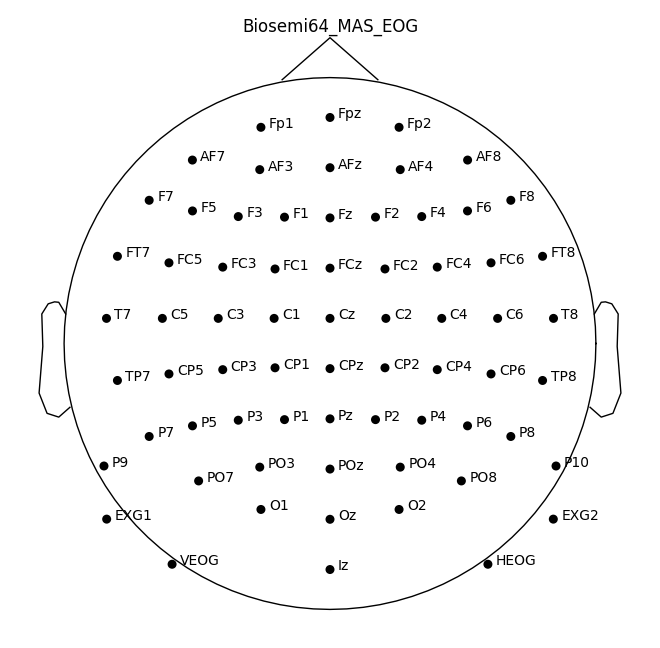

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [17]:
montage_biosemi.plot()

In [93]:
### Test on local computer - ICA exclude and autoR
# In[1]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
Preprocessing on Enrico data using MNE and ASR - cluster version
===============================================
We firstly import subject list from sbatch 
we define session list (1, 2), state list (VD, FA, OP), reject dict, 
then we import eeglab format Raw data of one state during one session for single subject with MNE package. We apply:
1) make sure that there is event 254 and event 255, and crop the raw data between 254 and 255
2) a notch filter to remove powerline artifact (50 Hz)
3) a 1Hz-100Hz band-pass filter

Then concatenate the data of the same session with annotation engineering, detail utils please turn to 
utils_preProcessingWorkflowJuly05.py
3) ASR and ICA fitting:
    we replicate ASR and load ica file
        
4) Autoreject and concatenate two sessions
====> output = full_epoch fif file that save the the full recording for one subject
Note: 
1. exception : subject 36, some subject can have several 254,255 events
------ please refer to excel Enrico recording summary.xlsx
2. events code: state + condition + session 
    1. state: 1:VD 2:FA 3:OP
    2. condition: 1:baseline 2:safe 3:threat
    3. session: 1:session1 2:session2
3. we fix sampling rate at 512 = for those file whose sfreq = 2048, we do a downsampling

Suggestions:
1) decide infomation storage format
2) 

Updated on July 2019

@author: Gansheng TAN aegean0045@outlook.com    based on Manu's codes
"""

##############################################################  Set-up header ###########################################
import mne
import importlib
import numpy as np
import numpy.matlib
from mne.report import Report
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from utils_ASR import *
from utils_PreprocessingWorkflowJuly23UpdatedData import *
from scipy.linalg import toeplitz
from scipy import signal
import sys
import encodings
import os

matplotlib.use('Agg')
mne.set_log_level('WARNING')

##################### OS path in INSERM computer #####################################################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
# # report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
full_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
#
##################### OS path in cluster ######################################################################
# raw_data_path = '/mnt/data/gansheng/raw_data/'
# montage_fname = '/mnt/data/gansheng/raw_data/Biosemi64_MAS_EOG.locs'
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
preProc_ica_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/preProc_ica/'
# full_epochs_path = '/mnt/data/gansheng/preClean_data/'


########################################## Algorithme parameter ############################################
cutoff = 4
pca_n_comp = 0.98
decim = 2

########################################## Initialization parameter##########################################
# subj_list = [sys.argv[1]]
subj_list = ['11']
session_list=['1','2']
#state list defines the concatenating order
# state_list = ['VD','FA','OP']
state_list = ['VD','FA','OP']
power_freq_array = [50]
reject_raw_data_session1 = {'74':['FA','OP','VD'],'62':['FA','OP','VD'],'75':['FA','OP','VD']}
reject_raw_data_session2 = {'74':['FA','OP','VD'],'62':['FA','OP','VD'],'75':['FA','OP','VD']}

# bad channel rejection is not apllied in the preproc, bad channels will be defined by eyes later
bad_channels={'02':{'1':['P2','FC5'],'2':['P2','FC5']},
              '04':{'2':['FC6']},
              '07':{'1':['Iz'],'2':['F8','T7','TP8']},
              '10':{'1':['F8','AF8','F6','Fp1','AF7','FC6','FT8'],'2':['Fp1','Fpz','Fp2','AF8','F8']},
              '11':{'2':['T8','F4']},
              '12':{'1':['P2']},
              '14':{'1':['P2'],'2':['P2']},
              '16':{'1':['Fp1','AF7','Fp2','AF8'],'2':['Fp1','AF7','Fp2','AF8','F6']},
              '19':{'1':['P2','T7'],'2':['P2']},
              '21':{'2':['Iz']},
              '22':{'1':['T7','TP7','Iz','P1','POz','Pz'],'2':['T7','TP7','Iz']},
              '25':{'1':['T8','Fp1'],'2':['FC1','C3','PO4','F2','Pz']},
              '26':{'1':['T8'],'2':['CPz']},
              '28':{'2':['CP2','PO7','Oz','POz']},
              '29':{'1':['F3','F5','F7','AF8','F4','F6','F8'],'2':['F6','T7','F3','F5','F7','AF8','F8']},
              '32':{'1':['P2'],'2':['P2','TP7']},
              '34':{'1':['P2'],'2':['P2']},
              '35':{'1':['T7','T8'],'2':['T8','PO8']},
              '36':{'1':['P2','PO4'],'2':['P2','PO4']},
              '37':{'1':['Iz']},
              '38':{'2':['C5','FC5','TP8']},
              '39':{'1':['P2','F8','AF8','Fp1','AF7'],'2':['P2','FT8','AF8','T8','P10']},
              '40':{'1':['P2','TP7'],'2':['P2','TP7']},
              '42':{'1':['P2'],'2':['P2']},
              '50':{'1':['T7']},
              '51':{'1':['P2'],'2':['P2']},
              '53':{'1':['T7'],'2':['T7']},
              '54':{'1':['P2'],'2':['P2']},
              '55':{'1':['Iz']},
              '56':{'1':['P2','T7'],'2':['P2','TP7']},
              '57':{'1':['P2'],'2':['P2']},
              '58':{'1':['P2','T8'],'2':['PO4']},
              '59':{'1':['P2','PO4']},
              '60':{'1':['P2'],'2':['P2']},
              '63':{'2':['PO8']},
              '64':{'1':['C1']},
              '65':{'1':['P2'],'2':['P2']},
              '67':{'1':['FT8']},
              '68':{'1':['P2'],'2':['P2']},
              '70':{'1':['PO4','O2','FC3','FC5','F4','F6'],'2':['PO4','O2','FC5','FC3']},
              '71':{'1':['P2','Iz'],'2':['P2','Iz','C1','Cz']},
              '73':{'2':['FCz','FT8']},
            #'75':{'1':['C6','P2','FT8','AF8','CP1','P9','PO4','O2']},
              '76':{'2':['T7']},
              '77':{'1':['F6'],'2':['O1','Oz','F6','O2']},
              '78':{'1':['P2'],'2':['P2']},
              '79':{'1':['P2','POz'],'2':['P2','POz','T7','Fp1','AF7']},
              '81':{'1':['Iz','Oz','Pz','CPz','PO4','P2','POz'],'2':['Iz','Oz','POz','CPz','P2','PO4','FC1','C1','Pz']},
              '82':{'1':['P2'],'2':['AFz']},
              '83':{'1':['T7'],'2':['T7']},
              '87':{'2':['P2']},
              '88':{'1':['FC2','T8'],'1':['F4','P8','CP4']},
              '90':{'1':['T7','P2'],'2':['P2']},
              '91':{'1':['P2'],'2':['P2']},
              '93':{'1':['FC5','Fp1','F3','PO4'],'2':['Fp1','F3','FC3','PO4']},
              '94':{'1':['Fp1','F6','AF8','Fp2','T7','T8'],'2':['Fp1','F6','AF8','Fp2','T7']},
              '95':{'1':['P2'],'2':['P2']}
             }


compnts2exclude_ica =     {'02':{'1':[0,17,18,20,22],'2':[0,17,11,15,23]},
                           '04':{'1':[0,1,6,12,13,14,17],'2':[0,19,16,14,15]},
                           '07':{'1':[1,4,0,20,31,33,36],'2':[28,26,1]},
                           '10':{'1':[0,4],'2':[0]},
                           '11':{'1':[0,11,12,13],'2':[0,12,13]},
                           '12':{'1':[0,1,3,19,20,21,22,23],'2':[0,4,2,19,14,15,16,22,23]},
                           '14':{'1':[2,13,17,8,16,18,20,31,30],'2':[0,1,7,10,12,25,26,28,22]},
                           '16':{'1':[1,3,6,5,9,14,15,22,23],'2':[1,7,12,14]},
                           '18':{'1':[1,7,3,14,17,18,19,22,23,26,24],'2':[0,4,9,18,19,20,25,27,28]},
                           '19':{'1':[0,1,9,11,12,23,21],'2':[9,8,16,20,28]},
                           '21':{'1':[0,8,13,15,17,11],'2':[0,10,18,19,20,24]},
                           '22':{'1':[0,6,8,11],'2':[1,7,9,12,18,14,19,15,16,17]},
                           '25':{'1':[0,9,23,15,16,17],'2':[0,18,17,12,21]},
                           '26':{'1':[0,5,14,15,17],'2':[6,8,11,12,21]},
                           '28':{'1':[0,10,12,16,17,24,23,32],'2':[0,6,13,15,21,23]},
                           '29':{'1':[1,4,8,13],'2':[0,8,20]},
                           '30':{'1':[0,6,12,13,18,19,21,22,24],'2':[0,10,13,14,18,19,20,21,23,24,25,29]},
                           '32':{'1':[14,12,13,20,21,24,25],'2':[1,6,7,19,18,17,21]},
                           '34':{'1':[0,7,11,17,15,21,22,32],'2':[0,4,11,16,24,30,31,35]},
                           '35':{'1':[0,2,18,23,34,37,38,41],'2':[10,17,43]},
                           '36':{'1':[0,4,9,16,20,25,23,27],'2':[0,3,4,8,9,15,17,19,21]},
                           '37':{'1':[0,27,22,31,41,42],'2':[0,7,21,22,38,33]},
                           '38':{'1':[5,4,8,11,18,17,16,20,26,27,29],'2':[0,2,5,19,22,27,36,35,34]},
                           '39':{'1':[0,18,21],'2':[2,27]},
                           '40':{'1':[0,5,4,13,15,12,29,25,23,30],'2':[0,9,14,10,16,19,29,23,24,20,32]},
                           '42':{'1':[0,5,10,18,14,15,21,24],'2':[0,10,15,17]},
                           '50':{'1':[1,3,5,7,16,10,19,30],'2':[3,4,5,6,7,13]},
                           '51':{'1':[0,3,4,5,7,8,10,11,12,14,16],'2':[1,13,11,16]},
                           '52':{'1':[0,12,13,22],'2':[1,31,34]},
                           '53':{'1':[5,6,13,16,21,23,20,22,33,34],'2':[5,8,14,18,19,22,23,21]},
                           '54':{'1':[0,20,23,25,31,34],'2':[0,15,25,30,31]},
                           '55':{'1':[0,10,16,14,15,18],'2':[2,8,7,11,14,13,15,16]},
                           '56':{'1':[1,10,24,25],'2':[3,6,15,14,21,28]},
                           '57':{'1':[],'2':[18]},
                           '58':{'1':[0,10,14,22,23],'2':[0,16,21,26,27]},
                           '59':{'1':[0,1,19,12,28,35],'2':[1,10,13,17,21,20,28,32,33]},
                           '60':{'1':[2,6,9,11,17,19,20,27,34],'2':[5,6,8,17,10,11,19,20,28,29]},
                           '63':{'1':[4,14,19,15,20,29],'2':[6,11,16,21]},
                           '64':{'1':[0,17,11,19],'2':[1]},
                           '65':{'1':[1,9,15,16,17,18,14],'2':[2,3,11,12,17,20,24,26,28,29,39]},
                           '67':{'1':[5,9,16,20],'2':[0,5,34,26,38]},
                           '68':{'1':[13,14,15,17,1],'2':[0,12,14,15,17]},
                           '69':{'1':[3,15,16,14],'2':[8,12,13]},
                           '70':{'1':[5,4,6,9,11,0,15,20,25,31,30],'2':[0,8,17,25]},
                           '71':{'1':[1,9,26,29,37],'2':[1,15]},
                           '72':{'1':[1,4,11,15,17],'2':[0,10,14,17,18,19,20,21,22]},
                           '73':{'1':[2,8,9,10,13,14,15,16,18,19,26,28,29,22,30,32],'2':[9,17,23,24,26,31]},
                           '78':{'1':[0,5,19,11,14],'2':[0,7,8,31]},
                           '79':{'1':[0,1,2,6,7,8,10,14,15,16,27,25,28],'2':[3,0,2,7,9,11,13]},
                           '80':{'1':[7],'2':[1,7,18,20,21,23,26,28]},
                           '81':{'1':[0,10,11],'2':[0,13,11]},
                           '82':{'1':[0,15,13,16,17,18],'2':[3,12,15,16,17]},
                           '83':{'1':[0,9,17,7,4,10,14,19,22,28],'2':[0,4,14,12,13,7,15]},
                           '87':{'1':[1,13,15,19,25,33,31,4,7,9],'2':[1,2,8,10,14,13,15,19,24,20]},
                           '88':{'1':[1,4,9,14,16,18,20],'2':[0,4,6,9]},
                           '90':{'1':[1,9,12,19,25],'2':[0,7,12,21]},
                           '91':{'1':[2,17,15,20,21,22,23],'2':[1,13]},
                           '93':{'1':[0,9,6,10,15],'2':[0,8,16]},
                           '94':{'1':[0,6,9,18,14,16,19,25],'2':[0,5,10,13]},
                           '95':{'1':[0,14,15,17,18,19,20,21],'2':[1,3,15]},
                           '96':{'1':[0,17,20],'2':[0,10,21,22]},
                           '76':{'1':[0,14,15,21],'2':[1,10,11,22,27,28,29,32,33]},
                           '77':{'1':[0,1,14,28,45],'2':[0]},
                    
                          }

# normal ones 110 75 (48subjs)
# subjs=['02', '04', '07', '11', '12', '14', '16', '18', '19', '21', '22', '26', '28', '30',
#        '32', '34', '36', '37', '38', '40', '42', '50', '51', '52', '53', '54', '55', '56', '58', '59',
#        '60', '63', '65', '67', '68', '70', '72', '73', '78', '83', '87', '88', '90', '91', '93', '94', '95', '96']

#subject acquire specific parameters 130 75(10 subjs)
#SUBJECTS=(10 25 29 39 57 64 69 80 81 82)

#subject acquire specific parameters 140 75(4 subjs)
#SUBJECTS=(35 71 76 77)

#subject acquire specific parameters 160 75(1subj)
#SUBJECTS=(79)

# set-aside subjs 74,75,62

################################ step00: cut and filter data and concatenate 3 recording in one session ############

###### set up montage
montage_biosemi=mne.channels.read_montage(montage_fname)

###### preproc for each raw file
for subj in subj_list:
    psd_full_figs=[]
    psd_full_caption=[]
    session2conctn_list=[]
    ############### single subject report ###########################
    rep_fname = report_path + 'subj0' + subj+'ica report.h5'
    rep = mne.open_report(rep_fname)
    
    for session in session_list:
        autoR_figs=[]
        autoR_captions = []
        epochs_ASR_clean = get_epochs_ASR_clean(subj,session)[0]
        if epochs_ASR_clean == False:
            continue
        else:
            ############### step02 ICA components exclusion ##########################
            preProc_ica_fname = preProc_ica_path+'subj0'+subj+'session'+session+'preProc_ica.fif'
            ica = mne.preprocessing.read_ica(preProc_ica_fname)
            ica.exclude=compnts2exclude_ica[subj][session]
            ica.apply(epochs_ASR_clean)

            ################### step03 AutoRejection ##################################
            picks = mne.pick_types(epochs_ASR_clean.info, meg=False, eeg=True, stim=False,
                   eog=False)
#             ar = AutoReject(picks=picks,random_state= 11,verbose='tqdm')
            ar = AutoReject(consensus=np.array([0.,2.0,4.0]),n_interpolate=[4],picks=picks,random_state= 11,verbose='tqdm')
            ar=ar.fit(epochs_ASR_clean)
            epochs_autorejected, reject_log = ar.transform(epochs_ASR_clean, return_log=True)
            reject_global_threshold = get_rejection_threshold(epochs_ASR_clean, decim=2,ch_types=['eeg'])
            while autorej_rate(epochs_autorejected) > 0.1:
                epochs_autorejected = epochs_ASR_clean.copy()
                reject_global_threshold['eeg']+=2e-05
                epochs_autorejected.drop_bad(reject=reject_global_threshold)
                print('reset global threshold')

            
            autoR_figs.append(epochs_autorejected.plot_drop_log())
            autoR_captions.append('autorejecting rate')
#             autoR_figs.append(reject_log.plot_epochs(epochs_ASR_clean,scalings=150e-6))
#             autoR_captions.append('a glimpse of autorejecting epochs')

            threshes = ar.threshes_
            unit = r'uV'
            scaling = 1e6

            thres_hist=plt.figure(figsize=(6, 5))
            plt.tick_params(axis='x', which='both', bottom='off', top='off')
            plt.tick_params(axis='y', which='both', left='off', right='off')

            plt.hist(scaling * np.array(list(threshes.values())), 30,
                     color='g', alpha=0.4)
            plt.xlabel('Threshold (%s)' % unit)
            plt.ylabel('Number of sensors')
            plt.tight_layout()
            autoR_figs.append(thres_hist)
            autoR_captions.append('threshold histogram')

#             rep.add_figs_to_section(figs=psd_figs, captions=psd_captions, section = 'session'+session+'spectral plot', 
#                                     image_format = 'svg')
#             rep.add_figs_to_section(figs=ASR_figs, captions=ASR_captions, section = 'session'+session+'ASR plot', 
#                                     image_format = 'svg')
#             rep.add_figs_to_section(figs=ica_figs, captions=ica_captions, section = 'session'+session+'ica plot', 
#                                     image_format = 'svg')
            rep.add_figs_to_section(figs=autoR_figs, captions=autoR_captions, section = 'session'+session+
                                    'autoRejection plot', image_format = 'svg')

            session2conctn_list.append(epochs_autorejected)
    full_epochs_fname = full_epochs_path + 'subj0'+subj+'full_epo.fif'
    full_epochs_autorejected = mne.concatenate_epochs(session2conctn_list)
    psd_full_figs.append(full_epochs_autorejected.plot_psd())
    psd_full_caption.append('psd of epochs after preprocessing')
    rep.add_figs_to_section(figs=psd_full_figs, captions=psd_full_caption, section = 'preprocessed full epochs plot',
                            image_format = 'svg')
    full_epochs_autorejected.save(full_epochs_fname,overwrite = True)
        
#     f_report = report_path + 'subj0' + subj+'.html'
    rep.save(rep_fname, open_browser = False, overwrite = True)
    print('finished')

        


Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj011_VD1_mast.fdt
Reading 0 ... 225402  =      0.000 ...   440.238 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

Computing thresholds ...:  38%|███▊      | 24/64 [03:34<06:01,  9.03s/it]

KeyboardInterrupt: 

In [ ]:
### cluster version
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
Preprocessing on Enrico data using MNE and ASR - cluster version
===============================================
We firstly import subject list from sbatch 
we define session list (1, 2), state list (VD, FA, OP), reject dict, 
then we import eeglab format Raw data of one state during one session for single subject with MNE package. We apply:
1) make sure that there is event 254 and event 255, and crop the raw data between 254 and 255
2) a notch filter to remove powerline artifact (50 Hz)
3) a 1Hz-100Hz band-pass filter

Then concatenate the data of the same session with annotation engineering, detail utils please turn to 
utils_preProcessingWorkflowJuly05.py
3) ASR and ICA fitting:
    we replicate ASR and load ica file
        
4) Autoreject and concatenate two sessions
====> output = full_epoch fif file that save the the full recording for one subject
Note: 
1. exception : subject 36, some subject can have several 254,255 events
------ please refer to excel Enrico recording summary.xlsx
2. events code: state + condition + session 
    1. state: 1:VD 2:FA 3:OP
    2. condition: 1:baseline 2:safe 3:threat
    3. session: 1:session1 2:session2
3. we fix sampling rate at 512 = for those file whose sfreq = 2048, we do a downsampling

Suggestions:
1) decide infomation storage format
2) 

Updated on July 2019

@author: Gansheng TAN aegean0045@outlook.com    based on Manu's codes
"""

##############################################################  Set-up header ###########################################
import mne
import importlib
import numpy as np
import numpy.matlib
from mne.report import Report
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from utils_ASR import *
from utils_PreprocessingWorkflowJuly23UpdatedData import *
from scipy.linalg import toeplitz
from scipy import signal
import sys
import encodings
import os

matplotlib.use('Agg')
mne.set_log_level('WARNING')

##################### OS path in INSERM computer #####################################################################
# raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
# montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
# # report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
# full_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
# #
##################### OS path in cluster ######################################################################
raw_data_path = '/mnt/data/gansheng/raw_data/'
montage_fname = '/mnt/data/gansheng/raw_data/Biosemi64_MAS_EOG.locs'
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
preProc_ica_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/preProc_ica/'
full_epochs_path = '/mnt/data/gansheng/preClean_data/'


########################################## Algorithme parameter ############################################
cutoff = 4
pca_n_comp = 0.98
decim = 2

########################################## Initialization parameter##########################################
subj_list = [sys.argv[1]]
# subj_list = ['02']
session_list=['1','2']
#state list defines the concatenating order
# state_list = ['VD','FA','OP']
state_list = ['VD','FA','OP']
power_freq_array = [50]
reject_raw_data_session1 = {'74':['FA','OP','VD'],'62':['FA','OP','VD'],'75':['FA','OP','VD']}
reject_raw_data_session2 = {'74':['FA','OP','VD'],'62':['FA','OP','VD'],'75':['FA','OP','VD']}

# bad channel rejection is not apllied in the preproc, bad channels will be defined by eyes later
bad_channels={'02':{'1':['P2','FC5'],'2':['P2','FC5']},
              '04':{'2':['FC6']},
              '07':{'1':['Iz'],'2':['F8','T7','TP8']},
              '10':{'1':['F8','AF8','F6','Fp1','AF7','FC6','FT8'],'2':['Fp1','Fpz','Fp2','AF8','F8']},
              '11':{'2':['T8','F4']},
              '12':{'1':['P2']},
              '14':{'1':['P2'],'2':['P2']},
              '16':{'1':['Fp1','AF7','Fp2','AF8'],'2':['Fp1','AF7','Fp2','AF8','F6']},
              '19':{'1':['P2','T7'],'2':['P2']},
              '21':{'2':['Iz']},
              '22':{'1':['T7','TP7','Iz','P1','POz','Pz'],'2':['T7','TP7','Iz']},
              '25':{'1':['T8','Fp1'],'2':['FC1','C3','PO4','F2','Pz']},
              '26':{'1':['T8'],'2':['CPz']},
              '28':{'2':['CP2','PO7','Oz','POz']},
              '29':{'1':['F3','F5','F7','AF8','F4','F6','F8'],'2':['F6','T7','F3','F5','F7','AF8','F8']},
              '32':{'1':['P2'],'2':['P2','TP7']},
              '34':{'1':['P2'],'2':['P2']},
              '35':{'1':['T7','T8'],'2':['T8','PO8']},
              '36':{'1':['P2','PO4'],'2':['P2','PO4']},
              '37':{'1':['Iz']},
              '38':{'2':['C5','FC5','TP8']},
              '39':{'1':['P2','F8','AF8','Fp1','AF7'],'2':['P2','FT8','AF8','T8','P10']},
              '40':{'1':['P2','TP7'],'2':['P2','TP7']},
              '42':{'1':['P2'],'2':['P2']},
              '50':{'1':['T7']},
              '51':{'1':['P2'],'2':['P2']},
              '53':{'1':['T7'],'2':['T7']},
              '54':{'1':['P2'],'2':['P2']},
              '55':{'1':['Iz']},
              '56':{'1':['P2','T7'],'2':['P2','TP7']},
              '57':{'1':['P2'],'2':['P2']},
              '58':{'1':['P2','T8'],'2':['PO4']},
              '59':{'1':['P2','PO4']},
              '60':{'1':['P2'],'2':['P2']},
              '63':{'2':['PO8']},
              '64':{'1':['C1']},
              '65':{'1':['P2'],'2':['P2']},
              '67':{'1':['FT8']},
              '68':{'1':['P2'],'2':['P2']},
              '70':{'1':['PO4','O2','FC3','FC5','F4','F6'],'2':['PO4','O2','FC5','FC3']},
              '71':{'1':['P2','Iz'],'2':['P2','Iz','C1','Cz']},
              '73':{'2':['FCz','FT8']},
            #'75':{'1':['C6','P2','FT8','AF8','CP1','P9','PO4','O2']},
              '76':{'2':['T7']},
              '77':{'1':['F6'],'2':['O1','Oz','F6','O2']},
              '78':{'1':['P2'],'2':['P2']},
              '79':{'1':['P2','POz'],'2':['P2','POz','T7','Fp1','AF7']},
              '81':{'1':['Iz','Oz','Pz','CPz','PO4','P2','POz'],'2':['Iz','Oz','POz','CPz','P2','PO4','FC1','C1','Pz']},
              '82':{'1':['P2'],'2':['AFz']},
              '83':{'1':['T7'],'2':['T7']},
              '87':{'2':['P2']},
              '88':{'1':['FC2','T8'],'1':['F4','P8','CP4']},
              '90':{'1':['T7','P2'],'2':['P2']},
              '91':{'1':['P2'],'2':['P2']},
              '93':{'1':['FC5','Fp1','F3','PO4'],'2':['Fp1','F3','FC3','PO4']},
              '94':{'1':['Fp1','F6','AF8','Fp2','T7','T8'],'2':['Fp1','F6','AF8','Fp2','T7']},
              '95':{'1':['P2'],'2':['P2']}
             }


compnts2exclude_ica =     {'02':{'1':[0,17,18,20,22],'2':[0,17,11,15,23]},
                           '04':{'1':[0,1,6,12,13,14,17],'2':[0,19,16,14,15]},
                           '07':{'1':[1,4,0,20,31,33,36],'2':[28,26,1]},
                           '10':{'1':[0,4],'2':[0]},
                           '11':{'1':[0,11,12,13],'2':[0,12,13]},
                           '12':{'1':[0,1,3,19,20,21,22,23],'2':[0,4,2,19,14,15,16,22,23]},
                           '14':{'1':[2,13,17,8,16,18,20,31,30],'2':[0,1,7,10,12,25,26,28,22]},
                           '16':{'1':[1,3,6,5,9,14,15,22,23],'2':[1,7,12,14]},
                           '18':{'1':[1,7,3,14,17,18,19,22,23,26,24],'2':[0,4,9,18,19,20,25,27,28]},
                           '19':{'1':[0,1,9,11,12,23,21],'2':[9,8,16,20,28]},
                           '21':{'1':[0,8,13,15,17,11],'2':[0,10,18,19,20,24]},
                           '22':{'1':[0,6,8,11],'2':[1,7,9,12,18,14,19,15,16,17]},
                           '25':{'1':[0,9,23,15,16,17],'2':[0,18,17,12,21]},
                           '26':{'1':[0,5,14,15,17],'2':[6,8,11,12,21]},
                           '28':{'1':[0,10,12,16,17,24,23,32],'2':[0,6,13,15,21,23]},
                           '29':{'1':[1,4,8,13],'2':[0,8,20]},
                           '30':{'1':[0,6,12,13,18,19,21,22,24],'2':[0,10,13,14,18,19,20,21,23,24,25,29]},
                           '32':{'1':[14,12,13,20,21,24,25],'2':[1,6,7,19,18,17,21]},
                           '34':{'1':[0,7,11,17,15,21,22,32],'2':[0,4,11,16,24,30,31,35]},
                           '35':{'1':[0,2,18,23,34,37,38,41],'2':[10,17,43]},
                           '36':{'1':[0,4,9,16,20,25,23,27],'2':[0,3,4,8,9,15,17,19,21]},
                           '37':{'1':[0,27,22,31,41,42],'2':[0,7,21,22,38,33]},
                           '38':{'1':[5,4,8,11,18,17,16,20,26,27,29],'2':[0,2,5,19,22,27,36,35,34]},
                           '39':{'1':[0,18,21],'2':[2,27]},
                           '40':{'1':[0,5,4,13,15,12,29,25,23,30],'2':[0,9,14,10,16,19,29,23,24,20,32]},
                           '42':{'1':[0,5,10,18,14,15,21,24],'2':[0,10,15,17]},
                           '50':{'1':[1,3,5,7,16,10,19,30],'2':[3,4,5,6,7,13]},
                           '51':{'1':[0,3,4,5,7,8,10,11,12,14,16],'2':[1,13,11,16]},
                           '52':{'1':[0,12,13,22],'2':[1,31,34]},
                           '53':{'1':[5,6,13,16,21,23,20,22,33,34],'2':[5,8,14,18,19,22,23,21]},
                           '54':{'1':[0,20,23,25,31,34],'2':[0,15,25,30,31]},
                           '55':{'1':[0,10,16,14,15,18],'2':[2,8,7,11,14,13,15,16]},
                           '56':{'1':[1,10,24,25],'2':[3,6,15,14,21,28]},
                           '57':{'1':[],'2':[18]},
                           '58':{'1':[0,10,14,22,23],'2':[0,16,21,26,27]},
                           '59':{'1':[0,1,19,12,28,35],'2':[1,10,13,17,21,20,28,32,33]},
                           '60':{'1':[2,6,9,11,17,19,20,27,34],'2':[5,6,8,17,10,11,19,20,28,29]},
                           '63':{'1':[4,14,19,15,20,29],'2':[6,11,16,21]},
                           '64':{'1':[0,17,11,19],'2':[1]},
                           '65':{'1':[1,9,15,16,17,18,14],'2':[2,3,11,12,17,20,24,26,28,29,39]},
                           '67':{'1':[5,9,16,20],'2':[0,5,34,26,38]},
                           '68':{'1':[13,14,15,17,1],'2':[0,12,14,15,17]},
                           '69':{'1':[3,15,16,14],'2':[8,12,13]},
                           '70':{'1':[5,4,6,9,11,0,15,20,25,31,30],'2':[0,8,17,25]},
                           '71':{'1':[1,9,26,29,37],'2':[1,15]},
                           '72':{'1':[1,4,11,15,17],'2':[0,10,14,17,18,19,20,21,22]},
                           '73':{'1':[2,8,9,10,13,14,15,16,18,19,26,28,29,22,30,32],'2':[9,17,23,24,26,31]},
                           '78':{'1':[0,5,19,11,14],'2':[0,7,8,31]},
                           '79':{'1':[0,1,2,6,7,8,10,14,15,16,27,25,28],'2':[3,0,2,7,9,11,13]},
                           '80':{'1':[7],'2':[1,7,18,20,21,23,26,28]},
                           '81':{'1':[0,10,11],'2':[0,13,11]},
                           '82':{'1':[0,15,13,16,17,18],'2':[3,12,15,16,17]},
                           '83':{'1':[0,9,17,7,4,10,14,19,22,28],'2':[0,4,14,12,13,7,15]},
                           '87':{'1':[1,13,15,19,25,33,31,4,7,9],'2':[1,2,8,10,14,13,15,19,24,20]},
                           '88':{'1':[1,4,9,14,16,18,20],'2':[0,4,6,9]},
                           '90':{'1':[1,9,12,19,25],'2':[0,7,12,21]},
                           '91':{'1':[2,17,15,20,21,22,23],'2':[1,13]},
                           '93':{'1':[0,9,6,10,15],'2':[0,8,16]},
                           '94':{'1':[0,6,9,18,14,16,19,25],'2':[0,5,10,13]},
                           '95':{'1':[0,14,15,17,18,19,20,21],'2':[1,3,15]},
                           '96':{'1':[0,17,20],'2':[0,10,21,22]},
                           '76':{'1':[0,14,15,21],'2':[1,10,11,22,27,28,29,32,33]},
                           '77':{'1':[0,1,14,28,45],'2':[0]},
                    
                          }

# normal ones 110 75 (48subjs)
# subjs=['02', '04', '07', '11', '12', '14', '16', '18', '19', '21', '22', '26', '28', '30',
#        '32', '34', '36', '37', '38', '40', '42', '50', '51', '52', '53', '54', '55', '56', '58', '59',
#        '60', '63', '65', '67', '68', '70', '72', '73', '78', '83', '87', '88', '90', '91', '93', '94', '95', '96']

#subject acquire specific parameters 130 75(10 subjs)
#SUBJECTS=(10 25 29 39 57 64 69 80 81 82)

#subject acquire specific parameters 140 75(4 subjs)
#SUBJECTS=(35 71 76 77)

#subject acquire specific parameters 160 75(1subj)
#SUBJECTS=(79)

# set-aside subjs 74,75,62

################################ step00: cut and filter data and concatenate 3 recording in one session ############

###### set up montage
montage_biosemi=mne.channels.read_montage(montage_fname)

###### preproc for each raw file
for subj in subj_list:
    psd_full_figs=[]
    psd_full_caption=[]
    session2conctn_list=[]
    ############### single subject report ###########################
    rep_fname = report_path + 'subj0' + subj+'ica report.h5'
    rep = mne.open_report(rep_fname)
    
    for session in session_list:
        autoR_figs=[]
        autoR_captions = []
        epochs_ASR_clean = get_epochs_ASR_clean(subj,session)[0]
        if epochs_ASR_clean == False:
            continue
        else:
            ############### step02 ICA components exclusion ##########################
            preProc_ica_fname = preProc_ica_path+'subj0'+subj+'session'+session+'preProc_ica.fif'
            ica = mne.preprocessing.read_ica(preProc_ica_fname)
            ica.exclude=compnts2exclude_ica[subj][session]
            ica.apply(epochs_ASR_clean)

            ################### step03 AutoRejection ##################################
            picks = mne.pick_types(epochs_ASR_clean.info, meg=False, eeg=True, stim=False,
                   eog=False)
            ar = AutoReject(picks=picks,random_state= 11,verbose='tqdm',n_jobs = 8)
            ar=ar.fit(epochs_ASR_clean)
            epochs_autorejected, reject_log = ar.transform(epochs_ASR_clean, return_log=True)
            reject_global_threshold = get_rejection_threshold(epochs_ASR_clean,ch_types=['eeg'],decim=2)
            while autorej_rate(epochs_autorejected) > 0.1:
                epochs_autorejected = epochs_ASR_clean.copy()
                reject_global_threshold['eeg']+=7e-06
                epochs_autorejected.drop_bad(reject=reject_global_threshold)
                print('reset global threshold to {}, rejecting rate turns to {}'.format(reject_global_threshold,
                                                                                        autorej_rate(epochs_autorejected)))

            
            autoR_figs.append(epochs_autorejected.plot_drop_log())
            autoR_captions.append('autorejecting rate')
#             autoR_figs.append(reject_log.plot_epochs(epochs_ASR_clean,scalings=150e-6))
#             autoR_captions.append('a glimpse of autorejecting epochs')

            threshes = ar.threshes_
            unit = r'uV'
            scaling = 1e6

            thres_hist=plt.figure(figsize=(6, 5))
            plt.tick_params(axis='x', which='both', bottom='off', top='off')
            plt.tick_params(axis='y', which='both', left='off', right='off')

            plt.hist(scaling * np.array(list(threshes.values())), 30,
                     color='g', alpha=0.4)
            plt.xlabel('Threshold (%s)' % unit)
            plt.ylabel('Number of sensors')
            plt.tight_layout()
            autoR_figs.append(thres_hist)
            autoR_captions.append('threshold histogram')

#             rep.add_figs_to_section(figs=psd_figs, captions=psd_captions, section = 'session'+session+'spectral plot', 
#                                     image_format = 'svg')
#             rep.add_figs_to_section(figs=ASR_figs, captions=ASR_captions, section = 'session'+session+'ASR plot', 
#                                     image_format = 'svg')
#             rep.add_figs_to_section(figs=ica_figs, captions=ica_captions, section = 'session'+session+'ica plot', 
#                                     image_format = 'svg')
            rep.add_figs_to_section(figs=autoR_figs, captions=autoR_captions, section = 'session'+session+
                                    'autoRejection plot', image_format = 'svg')

            session2conctn_list.append(epochs_autorejected)
            print('one session autoR is done')
    full_epochs_fname = full_epochs_path + 'subj0'+subj+'full_epo.fif'
    full_epochs_autorejected = mne.concatenate_epochs(session2conctn_list)
    psd_full_figs.append(full_epochs_autorejected.plot_psd())
    psd_full_caption.append('psd of epochs after preprocessing')
    rep.add_figs_to_section(figs=psd_full_figs, captions=psd_full_caption, section = 'preprocessed full epochs plot',
                            image_format = 'svg')
    full_epochs_autorejected.save(full_epochs_fname,overwrite = True)
        
#     f_report = report_path + 'subj0' + subj+'.html'
    rep.save(rep_fname, open_browser = False, overwrite = True)

        


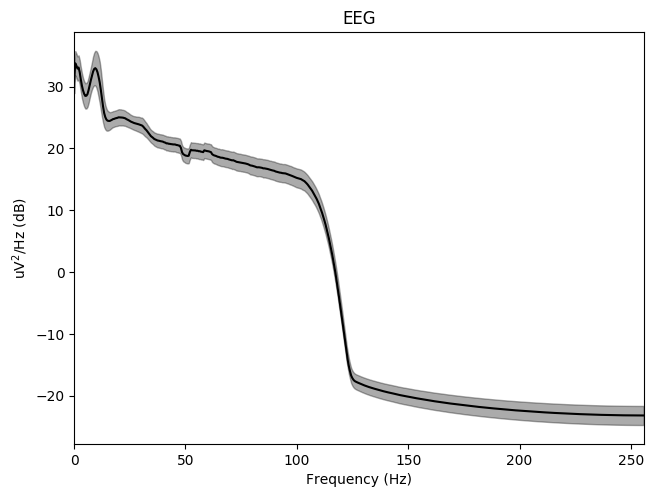

In [21]:
%matplotlib qt
full_epochs_autorejected.plot_psd()
full_epochs_VD =full_epochs_autorejected['111.0','121.0','131.0','112.0','122.0','132.0']
full_epochs_FA =full_epochs_autorejected['211.0','221.0','231.0','212.0','222.0','232.0']
full_epochs_OP =full_epochs_autorejected['311.0','321.0','331.0','312.0','322.0','332.0']
full_epochs_VD.plot_psd()
full_epochs_FA.plot_psd()
full_epochs_OP.plot_psd()

In [ ]:
def autorej_rate(epochs_autorejected):
    epoch_num = 0
    drop_epoch = 0
    for epoch in epochs_autorejected.drop_log:
        epoch_num+=1
        if not epoch:
            continue
        else:
            drop_epoch+=1
    rejecting_rate = drop_epoch/epoch_num
    return rejecting_rate

In [1]:
################ Visualization of bad channels ######################
################## with the help of psd plot ######################
%matplotlib qt
import mne
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
subj ='61'
state='VD'
session='2'
raw_fname = raw_data_path + 'subj0'+subj+'_'+state+session+'_mast.set'
montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
montage_biosemi=mne.channels.read_montage(montage_fname)
raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')  
raw.filter(l_freq=1,h_freq=100)
raw.plot(scalings=50e-6,n_channels=32,duration=15)
raw.plot_psd()
raw.plot_psd(picks=['Iz','PO4','P2'])

OSError: The file /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj061_VD2_mast.set does not exist.

In [18]:
raw.info

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, ...
    chs : list | 66 items (EOG: 2, EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 66 items (66 EEG)
    events : list | 0 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 66
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 512.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplot